# Segmentação de imagens zero-shot

https://huggingface.co/CIDAS/clipseg-rd64-refined

In [32]:
from transformers import pipeline

modelo = "CIDAS/clipseg-rd64-refined"
segmentador = pipeline("image-segmentation", model=modelo)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
The model 'CLIPSegForImageSegmentation' is not supported for image-segmentation. Supported models are ['DetrForSegmentation', 'BeitForSemanticSegmentation', 'Data2VecVisionForSemanticSegmentation', 'DPTForSemanticSegmentation', 'MobileNetV2ForSemanticSegmentation', 'MobileViTForSemanticSegmentation', 'MobileViTV2ForSemanticSegmentation', 'SegformerForSemanticSegmentation', 'UperNetForSemanticSegmentation', 'MaskFormerForInstanceSegmentation', 'Mask2FormerForUniversalSegmentation', 'OneFormerForUniversalSegmentation'].


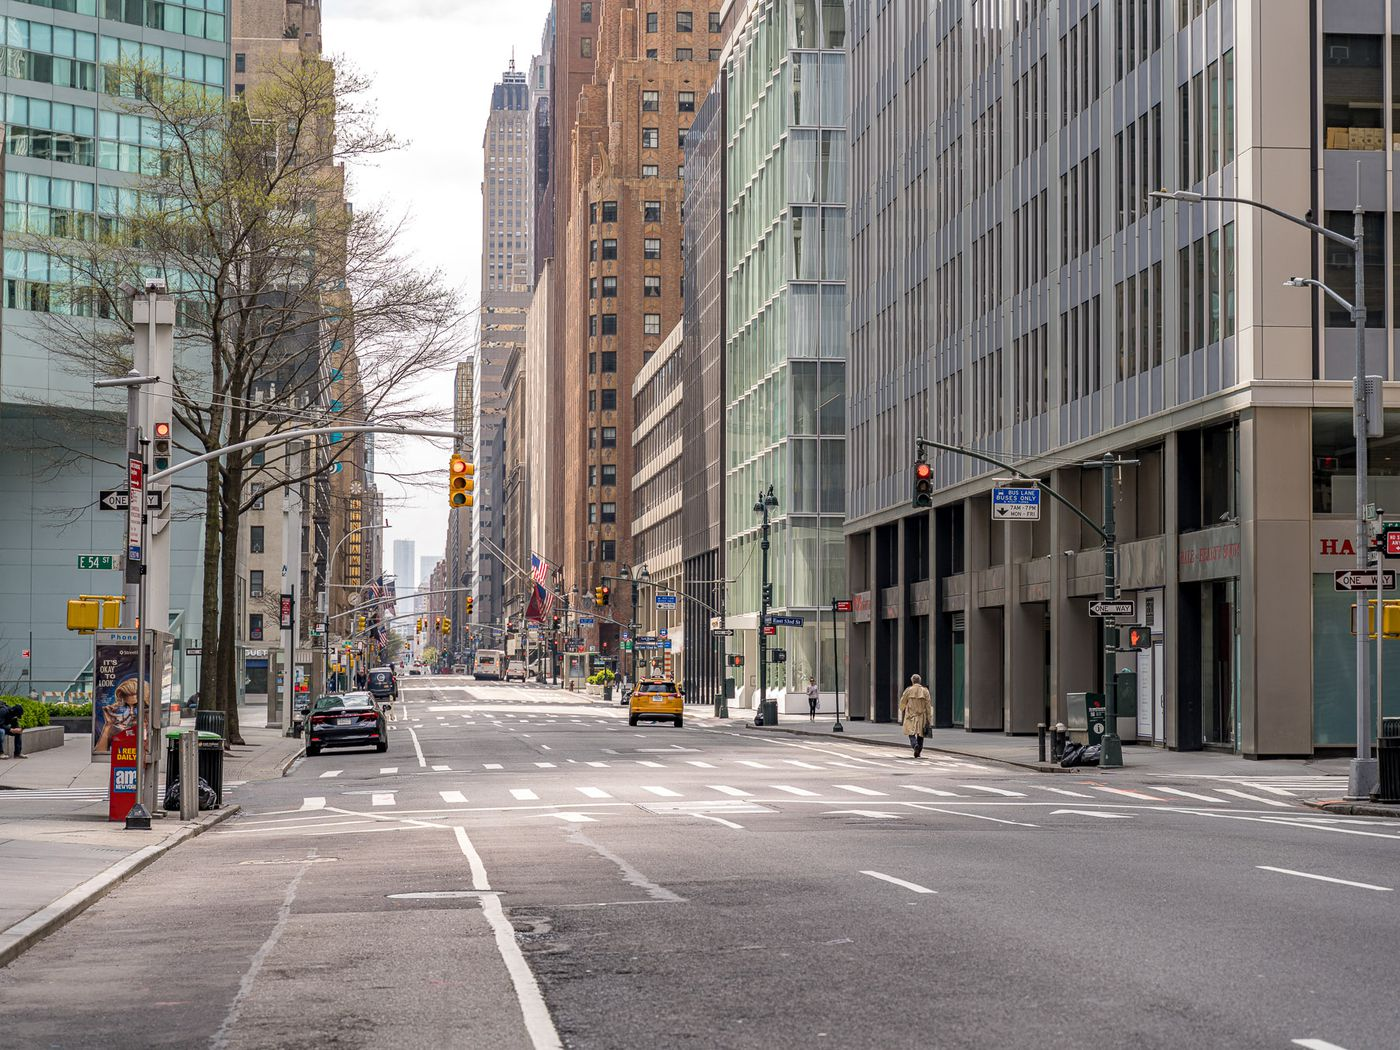

In [33]:
from pathlib import Path
from PIL import Image

imagem = Image.open(Path('imagens/cidades/city.jpg'))
imagem

In [34]:
segmentacao = segmentador(imagem)

ValueError: Invalid conditional, should be either provided as `input_ids` or `conditional_pixel_values`

Não vamos conseguir segmentar dessa forma porque este modelo não está pronto dentro da lógica do pipeline.

Se voltarmos para a [página do modelo](https://huggingface.co/CIDAS/clipseg-rd64-refined), encontramos um link com as instruções de uso:

In [35]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [36]:
prompts = ["street", "cars", "traffic light"]

inputs = processor(
    text=prompts,
    images=[imagem] * len(prompts),
    padding=True,
    return_tensors="pt",
)

Unused or unrecognized kwargs: padding.


In [37]:
import torch

# Faz a segmentação aqui
with torch.no_grad():
  outputs = model(**inputs)

predicoes = outputs.logits.unsqueeze(1)

In [38]:
predicoes

tensor([[[[-6.8384, -6.8212, -6.6755,  ..., -6.8139, -6.8652, -6.9856],
          [-6.7418, -6.5010, -6.4994,  ..., -6.7191, -6.8164, -6.8900],
          [-6.5009, -6.2851, -6.3303,  ..., -6.5247, -6.6202, -6.7266],
          ...,
          [-0.9824, -0.7518, -0.5765,  ...,  0.0975, -0.1220, -0.3271],
          [-1.3089, -1.0985, -0.9535,  ..., -0.2811, -0.5273, -0.7340],
          [-1.7022, -1.5501, -1.3419,  ..., -0.7054, -0.8838, -1.0131]]],


        [[[-8.3566, -8.2637, -8.2498,  ..., -8.1143, -8.1406, -8.2564],
          [-8.2974, -7.9776, -8.0568,  ..., -8.0925, -8.1827, -8.2342],
          [-8.0616, -7.8763, -7.9948,  ..., -7.9631, -8.1173, -8.1952],
          ...,
          [-7.9475, -7.8381, -7.8547,  ..., -7.3193, -7.5706, -7.7700],
          [-8.0265, -8.0023, -7.9838,  ..., -7.4466, -7.7309, -7.9299],
          [-8.2033, -8.2564, -8.1199,  ..., -7.7445, -7.8585, -8.1384]]],


        [[[-7.0140, -6.9857, -6.8068,  ..., -7.1571, -7.2221, -7.3681],
          [-6.9261, -6.672

In [39]:
segmentacao = []
for i, label in enumerate(prompts):
    segmentacao.append({
        'label': label,
        'mask': torch.sigmoid(predicoes[i][0]).numpy(),
    })
segmentacao

[{'label': 'street',
  'mask': array([[0.00107069, 0.00108924, 0.0012599 , ..., 0.00109715, 0.00104239,
          0.00092421],
         [0.00117917, 0.00149961, 0.00150203, ..., 0.00120619, 0.00109441,
          0.00101685],
         [0.00149989, 0.00186035, 0.00177826, ..., 0.00146466, 0.00133145,
          0.00119723],
         ...,
         [0.27241683, 0.32043663, 0.3597301 , ..., 0.5243464 , 0.46954867,
          0.41893873],
         [0.21267636, 0.25001422, 0.27817222, ..., 0.43018427, 0.37114593,
          0.32431686],
         [0.15417784, 0.17507102, 0.20719883, ..., 0.33062455, 0.2923955 ,
          0.26637486]], dtype=float32)},
 {'label': 'cars',
  'mask': array([[0.00023478, 0.00025765, 0.00026123, ..., 0.00029913, 0.00029138,
          0.00025953],
         [0.00024911, 0.00034294, 0.00031683, ..., 0.00030572, 0.00027938,
          0.00026534],
         [0.00031533, 0.00037951, 0.00033711, ..., 0.00034795, 0.00029824,
          0.00027589],
         ...,
         [0.0003

Próximo problema: os resultados aqui são "máscaras de probabilidade", sem uma corte fixo entre o que é e o que não é o objeto. Podemos visualizá-los assim:

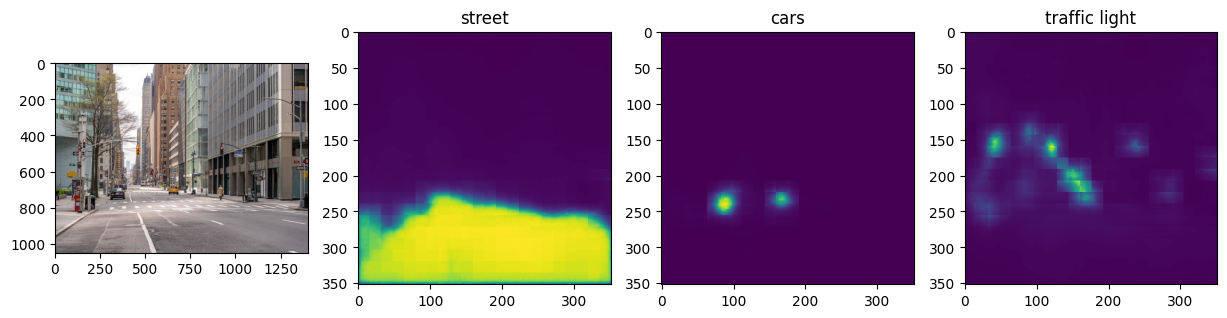

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(prompts) + 1, figsize=(15, 4))
ax[0].imshow(imagem)

for i, segmento in enumerate(segmentacao, 1):
    ax[i].imshow(segmento['mask'], cmap='viridis')
    ax[i].set_title(segmento['label'])

Além de serem probabilidades, as imagens não estão na mesma resolução da imagem original!

Em princípio, não há local na documentação informando como fazer um ajuste de resolução (se possível).Poderíamos consertar isso mais pra frente, usando algum algoritmo de upscaling.

Pelo menos, podemos transformar probabilidades em máscaras de verdade com o código a seguir:

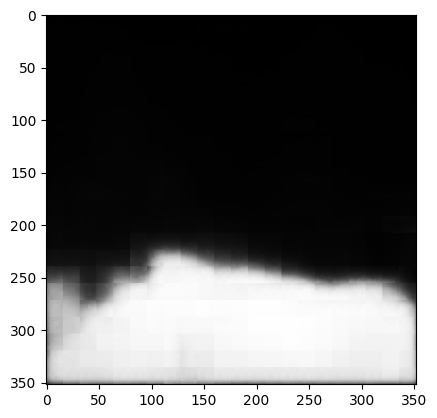

In [66]:
imagem_predicao = segmentacao[0]['mask']
plt.imshow(imagem_predicao, cmap='binary_r')

(array([82816.,  2270.,  1314.,   993.,  1210.,  1258.,  1533.,  2197.,
         4858., 25455.]),
 array([7.24630314e-04, 8.94727409e-02, 1.78220853e-01, 2.66968966e-01,
        3.55717093e-01, 4.44465190e-01, 5.33213317e-01, 6.21961415e-01,
        7.10709512e-01, 7.99457669e-01, 8.88205767e-01]),
 <BarContainer object of 10 artists>)

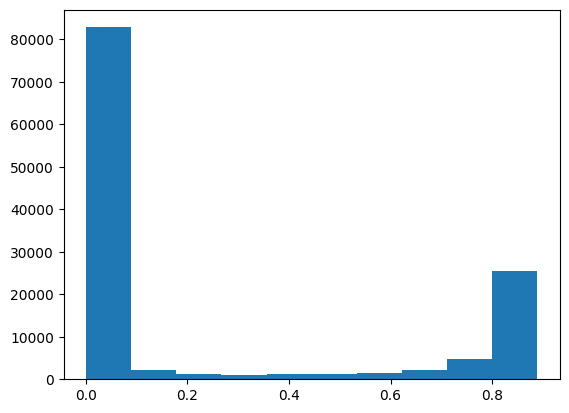

In [67]:
plt.hist(imagem_predicao.ravel())

Esta imagem está com boa separação entre o que ela acha que é rua, e o que não é. Vamos aplicar o ponto de corte em 0.7:

In [83]:
import numpy as np

threshold = 0.7

mascara_predicao = np.where(imagem_predicao < threshold, 0.0, imagem_predicao)
mascara_predicao = np.where(mascara_predicao > threshold, 255, mascara_predicao)
mascara_predicao = mascara_predicao.astype(int)

(array([93270.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 30634.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

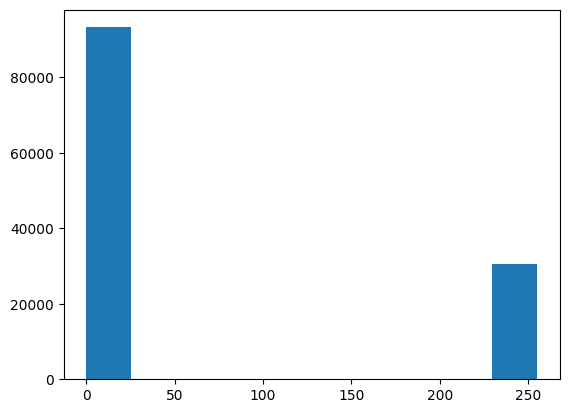

In [84]:
plt.hist(mascara_predicao.ravel())

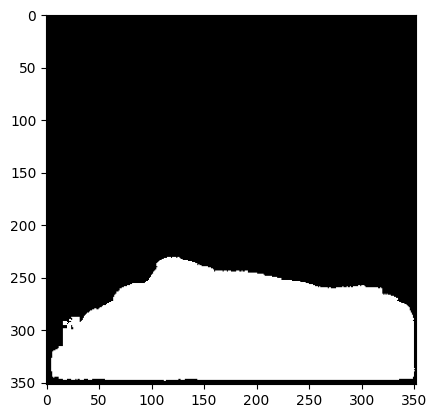

In [85]:
plt.imshow(mascara_predicao, cmap='binary_r')

## Outros modelos

Modelos de segmentação zero-shot são incipientes. Um exemplo promissor (da Meta) está aqui: https://segment-anything.com/, mas ainda não está disponível no Hugging Face.